In [ ]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [1]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import sys
sys.path.append('./')
from KLearn import *
from functools import reduce
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
from pylab import *
from scipy.optimize import curve_fit

In [3]:
# Define Operators

# Identity Operator (Linear)
def op_I(u):
    return u

# Scaling Operator (Linear)
def op_a(u):
    a = 10;
    return a*u

# Differentiation operator
def op_diff(u,x):
    return np.gradient(u, x, axis=0)

# Discrete Integration (Linear, Discrete)
def op_int(u,x,N_mesh,N):
    ints = np.zeros((np.shape(u)))
    idx = []
    for i in range(0, N_mesh):
        idx.append(i)
        ints[i][:] = integrate.simpson(u[idx][:], x[idx], axis = 0)
    return ints

# Discrete Double Integration
def op_int2(u,x,N_mesh,N):
    return op_int(op_int(u,x,N_mesh,N),x,N_mesh,N)

# Squaring Operator (Slightly Nonlinear)
def op_square(u):
    return u**2

# Sine Operator (Contractive)
def op_sin(u):
    return np.sin(u)

# Cube Root Operator
def op_rt3(u):
    return np.sign(u) * (np.abs(u) ** (1 / 3))

In [4]:
### Generating Data

## GP kernel

def gp_kernel(t,σ):
  return np.exp( - (1/(2*σ**2))*t**2)

N_mesh = 100
a = 0
b = 1
x = np.linspace(a,b, N_mesh) # fine grid for visualization
X = x.reshape((-1,1))
dx = (b-a)/N_mesh

## compute pairwise distance matrix

dist_matrix = pairwise_distances(X,X)

## GP lengthscale
σ = 0.1
Cov_matrix = gp_kernel(dist_matrix, σ) + 1e-8*np.eye(N_mesh)
print(Cov_matrix)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)
Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

[[1.00000001e+00 9.94911470e-01 9.79800714e-01 ... 1.42487329e-21
  5.26916305e-22 1.92874985e-22]
 [9.94911470e-01 1.00000001e+00 9.94911470e-01 ... 3.81399159e-21
  1.42487329e-21 5.26916305e-22]
 [9.79800714e-01 9.94911470e-01 1.00000001e+00 ... 1.01053670e-20
  3.81399159e-21 1.42487329e-21]
 ...
 [1.42487329e-21 3.81399159e-21 1.01053670e-20 ... 1.00000001e+00
  9.94911470e-01 9.79800714e-01]
 [5.26916305e-22 1.42487329e-21 3.81399159e-21 ... 9.94911470e-01
  1.00000001e+00 9.94911470e-01]
 [1.92874985e-22 5.26916305e-22 1.42487329e-21 ... 9.79800714e-01
  9.94911470e-01 1.00000001e+00]]


In [5]:
def opL_fxn(u_train,v_train,u_test,v_test,X):
    # Finish setting up
    U = u_train;
    V = v_train;
    Y = X;

    # Define some Kernels again (this time, parameterized)
    K_ = lambda g: (lambda y1,y2 : rbf_kernel(y1,y2, gamma = g))
    S_ = lambda s : (lambda x1,x2 : rbf_kernel(x1,x2, gamma = s)) # lame, for now
    kgrid = np.linspace(10,100, 100)
    sgrid = 1/np.power(5,range(1,12))

    # LEARN AGAIN!
    D,scores_s,g_s = OpLearn(U,V, S_,sgrid, K_,kgrid,Y, report_scores = True)
    v_mod, scores_k, g_k = D(u_test);
    MSE_s = min(scores_s);
    MSE_k = min(scores_k);
    return v_mod, MSE_s, g_s, MSE_k, g_k

In [6]:
# Define Error Values
def err_vals(v_mod,v_test,g_s,MSE_s,g_k, MSE_k, Y):
    # L1 Error (Averaged over Each Test Function)
    L1_err = dx*sum(np.abs(v_mod(Y) - v_test))
    L1_err_abs = np.average(L1_err)
    L1_err_rel = np.average(np.divide(L1_err, dx*sum(np.abs(v_test))))

    # L2 Error (Averaged over Each Test Function)
    L2_err = np.sqrt(dx*sum(np.square(np.abs(v_mod(Y) - v_test))))
    L2_err_abs = np.average(L2_err)
    L2_err_rel = np.average(np.divide(L2_err, np.sqrt(dx*sum(np.square(np.abs(v_test))))))

    # L_inf Error (Averaged over Each Test Function)
    Linf_err = np.max(np.abs(v_mod(Y) - v_test),axis=0)
    Linf_err_abs = np.average(Linf_err)
    Linf_err_rel = np.average(np.divide(Linf_err, np.max(np.abs(v_test),axis=0)))
    return np.array([L1_err_abs, L1_err_rel, L2_err_abs, L2_err_rel, Linf_err_abs, Linf_err_rel, g_s, MSE_s, g_k, MSE_k])

In [7]:
def all_ops_err(u_train,u_test,X,N_mesh,N_train,N_test):
    v_train_I = op_I(u_train)
    v_test_I = op_I(u_test)
    v_mod_I, MSE_s_I, g_s_I, MSE_k_I, g_k_I = opL_fxn(u_train,v_train_I,u_test,v_test_I,X)
    err_vals_I = err_vals(v_mod_I,v_test_I, g_s_I, MSE_s_I, g_k_I, MSE_k_I, X)

    v_train_a = op_a(u_train)
    v_test_a = op_a(u_test)
    v_mod_a, MSE_s_a, g_s_a, MSE_k_a, g_k_a = opL_fxn(u_train,v_train_a,u_test,v_test_a,X)
    err_vals_a = err_vals(v_mod_a,v_test_a, g_s_a, MSE_s_a,  g_k_a, MSE_k_a, X)

    v_train_diff = op_diff(u_train,x)
    v_test_diff = op_diff(u_test,x)
    v_mod_diff, MSE_s_diff, g_s_diff, MSE_k_diff, g_k_diff = opL_fxn(u_train,v_train_diff,u_test,v_test_diff,X)
    err_vals_diff = err_vals(v_mod_diff,v_test_diff, g_s_diff, MSE_s_diff, g_k_diff, MSE_k_diff, X)
    
    v_train_int = op_int(u_train,X,N_mesh,N_train)
    v_test_int = op_int(u_test,X,N_mesh,N_test)
    v_mod_int, MSE_s_int, g_s_int, MSE_k_int, g_k_int = opL_fxn(u_train,v_train_int,u_test,v_test_int,X)
    err_vals_int = err_vals(v_mod_int,v_test_int, g_s_int, MSE_s_int, g_k_int, MSE_k_int, X)
    
    v_train_int2 = op_int2(u_train,X,N_mesh,N_train)
    v_test_int2 = op_int2(u_test,X,N_mesh,N_test)
    v_mod_int2, MSE_s_int2, g_s_int2, MSE_k_int2, g_k_int2 = opL_fxn(u_train,v_train_int2,u_test,v_test_int2,X)
    err_vals_int2 = err_vals(v_mod_int2,v_test_int2, g_s_int2, MSE_s_int2, g_k_int2, MSE_k_int2, X)
    
    v_train_sq = op_square(u_train)
    v_test_sq = op_square(u_test)
    v_mod_sq, MSE_s_sq, g_s_sq, MSE_k_sq, g_k_sq = opL_fxn(u_train,v_train_sq,u_test,v_test_sq,X)
    err_vals_sq = err_vals(v_mod_sq,v_test_sq, g_s_sq, MSE_s_sq, g_k_sq, MSE_k_sq, X)

    v_train_sin = op_sin(u_train)
    v_test_sin = op_sin(u_test)
    v_mod_sin, MSE_s_sin, g_s_sin, MSE_k_sin, g_k_sin = opL_fxn(u_train,v_train_sin,u_test,v_test_sin,X)
    err_vals_sin = err_vals(v_mod_sin,v_test_sin, g_s_sin, MSE_s_sin, g_k_sin, MSE_k_sin, X)
    
    v_train_rt3 = op_rt3(u_train)
    v_test_rt3 = op_rt3(u_test)
    v_mod_rt3, MSE_s_rt3, g_s_rt3, MSE_k_rt3, g_k_rt3 = opL_fxn(u_train,v_train_rt3,u_test,v_test_rt3,X)
    err_vals_rt3 = err_vals(v_mod_rt3,v_test_rt3, g_s_rt3, MSE_s_rt3, g_k_rt3, MSE_k_rt3, X)
    
    opL_errs = np.row_stack((err_vals_I,err_vals_a,err_vals_diff,err_vals_int,err_vals_int2,err_vals_sq,err_vals_sin,err_vals_rt3))
    return opL_errs

In [8]:
def Data_vals(N):
    N_train = N       # Number of training functions
    N_test  = 100     # Number of testing functions
    u_train = np.zeros((N_mesh, N_train))
    u_test  = np.zeros((N_mesh, N_test))

    for i in range(N_train):
      xi = np.random.randn(N_mesh)
      u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

    for i in range(N_test):
      xi = np.random.randn(N_mesh)
      u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)
        
    u_train = u_train*1./np.linalg.norm(u_train, axis=0)
    u_test = u_test*1./np.linalg.norm(u_test, axis=0)
    
    return u_train, u_test, N_train, N_test

In [9]:
## Training and test functions
N = [10, 20, 40, 80, 100, 140, 160, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2300, 2600, 2900, 3200, 3600, 4000, 4500, 5000, 6000, 7000, 8500, 10000]
Num_ops = 8
Errs_op_mesh = np.zeros((Num_ops,10,len(N)))

for i in range(0,len(N)):
    u_train, u_test, N_train, N_test = Data_vals(N[i])
    ERRS = all_ops_err(u_train,u_test,X,N_mesh,N_train,N_test)
    Errs_op_mesh[:,:,i] = ERRS[:,:]

Optimal gamma = 6.4e-05
Optimal gamma = 39.09090909090909
Optimal gamma = 6.4e-05
Optimal gamma = 39.09090909090909
Optimal gamma = 0.008
Optimal gamma = 43.63636363636363
Optimal gamma = 6.4e-05
Optimal gamma = 40.0
Optimal gamma = 6.4e-05
Optimal gamma = 21.81818181818182
Optimal gamma = 0.2
Optimal gamma = 95.45454545454545
Optimal gamma = 6.4e-05
Optimal gamma = 40.0
Optimal gamma = 2.048e-08
Optimal gamma = 10.0
Optimal gamma = 6.4e-05
Optimal gamma = 52.72727272727273
Optimal gamma = 6.4e-05
Optimal gamma = 52.72727272727273
Optimal gamma = 6.4e-05
Optimal gamma = 43.63636363636363
Optimal gamma = 6.4e-05
Optimal gamma = 39.09090909090909
Optimal gamma = 6.4e-05
Optimal gamma = 20.0
Optimal gamma = 0.2
Optimal gamma = 91.81818181818181
Optimal gamma = 6.4e-05
Optimal gamma = 58.18181818181818
Optimal gamma = 1.024e-07
Optimal gamma = 11.818181818181818
Optimal gamma = 6.4e-05
Optimal gamma = 47.27272727272727
Optimal gamma = 6.4e-05
Optimal gamma = 47.27272727272727
Optimal gamma

Optimal gamma = 0.0016
Optimal gamma = 10.0
Optimal gamma = 0.008
Optimal gamma = 50.90909090909091
Optimal gamma = 0.008
Optimal gamma = 50.90909090909091
Optimal gamma = 0.008
Optimal gamma = 50.0
Optimal gamma = 0.008
Optimal gamma = 36.36363636363636
Optimal gamma = 0.008
Optimal gamma = 21.81818181818182
Optimal gamma = 0.04
Optimal gamma = 94.54545454545455
Optimal gamma = 0.04
Optimal gamma = 55.45454545454545
Optimal gamma = 0.0016
Optimal gamma = 12.727272727272727
Optimal gamma = 0.008
Optimal gamma = 50.90909090909091
Optimal gamma = 0.008
Optimal gamma = 50.90909090909091
Optimal gamma = 0.008
Optimal gamma = 54.54545454545455
Optimal gamma = 0.008
Optimal gamma = 37.27272727272727
Optimal gamma = 0.008
Optimal gamma = 22.727272727272727
Optimal gamma = 0.04
Optimal gamma = 97.27272727272727
Optimal gamma = 0.04
Optimal gamma = 50.90909090909091
Optimal gamma = 0.0016
Optimal gamma = 15.454545454545453
Optimal gamma = 0.008
Optimal gamma = 51.81818181818182
Optimal gamma = 

In [10]:
# Package Error Values
L1_Errs = Errs_op_mesh[:,0,:]
L1_Errs_Rel = Errs_op_mesh[:,1,:]
L2_Errs = Errs_op_mesh[:,2,:]
L2_Errs_Rel = Errs_op_mesh[:,3,:]
Linf_Errs = Errs_op_mesh[:,4,:]
Linf_Errs_Rel = Errs_op_mesh[:,5,:]
Opt_Gamma_s = Errs_op_mesh[:,6,:]
Opt_MSE_s = Errs_op_mesh[:,7,:]
Opt_Gamma_k = Errs_op_mesh[:,8,:]
Opt_MSE_k = Errs_op_mesh[:,9,:]

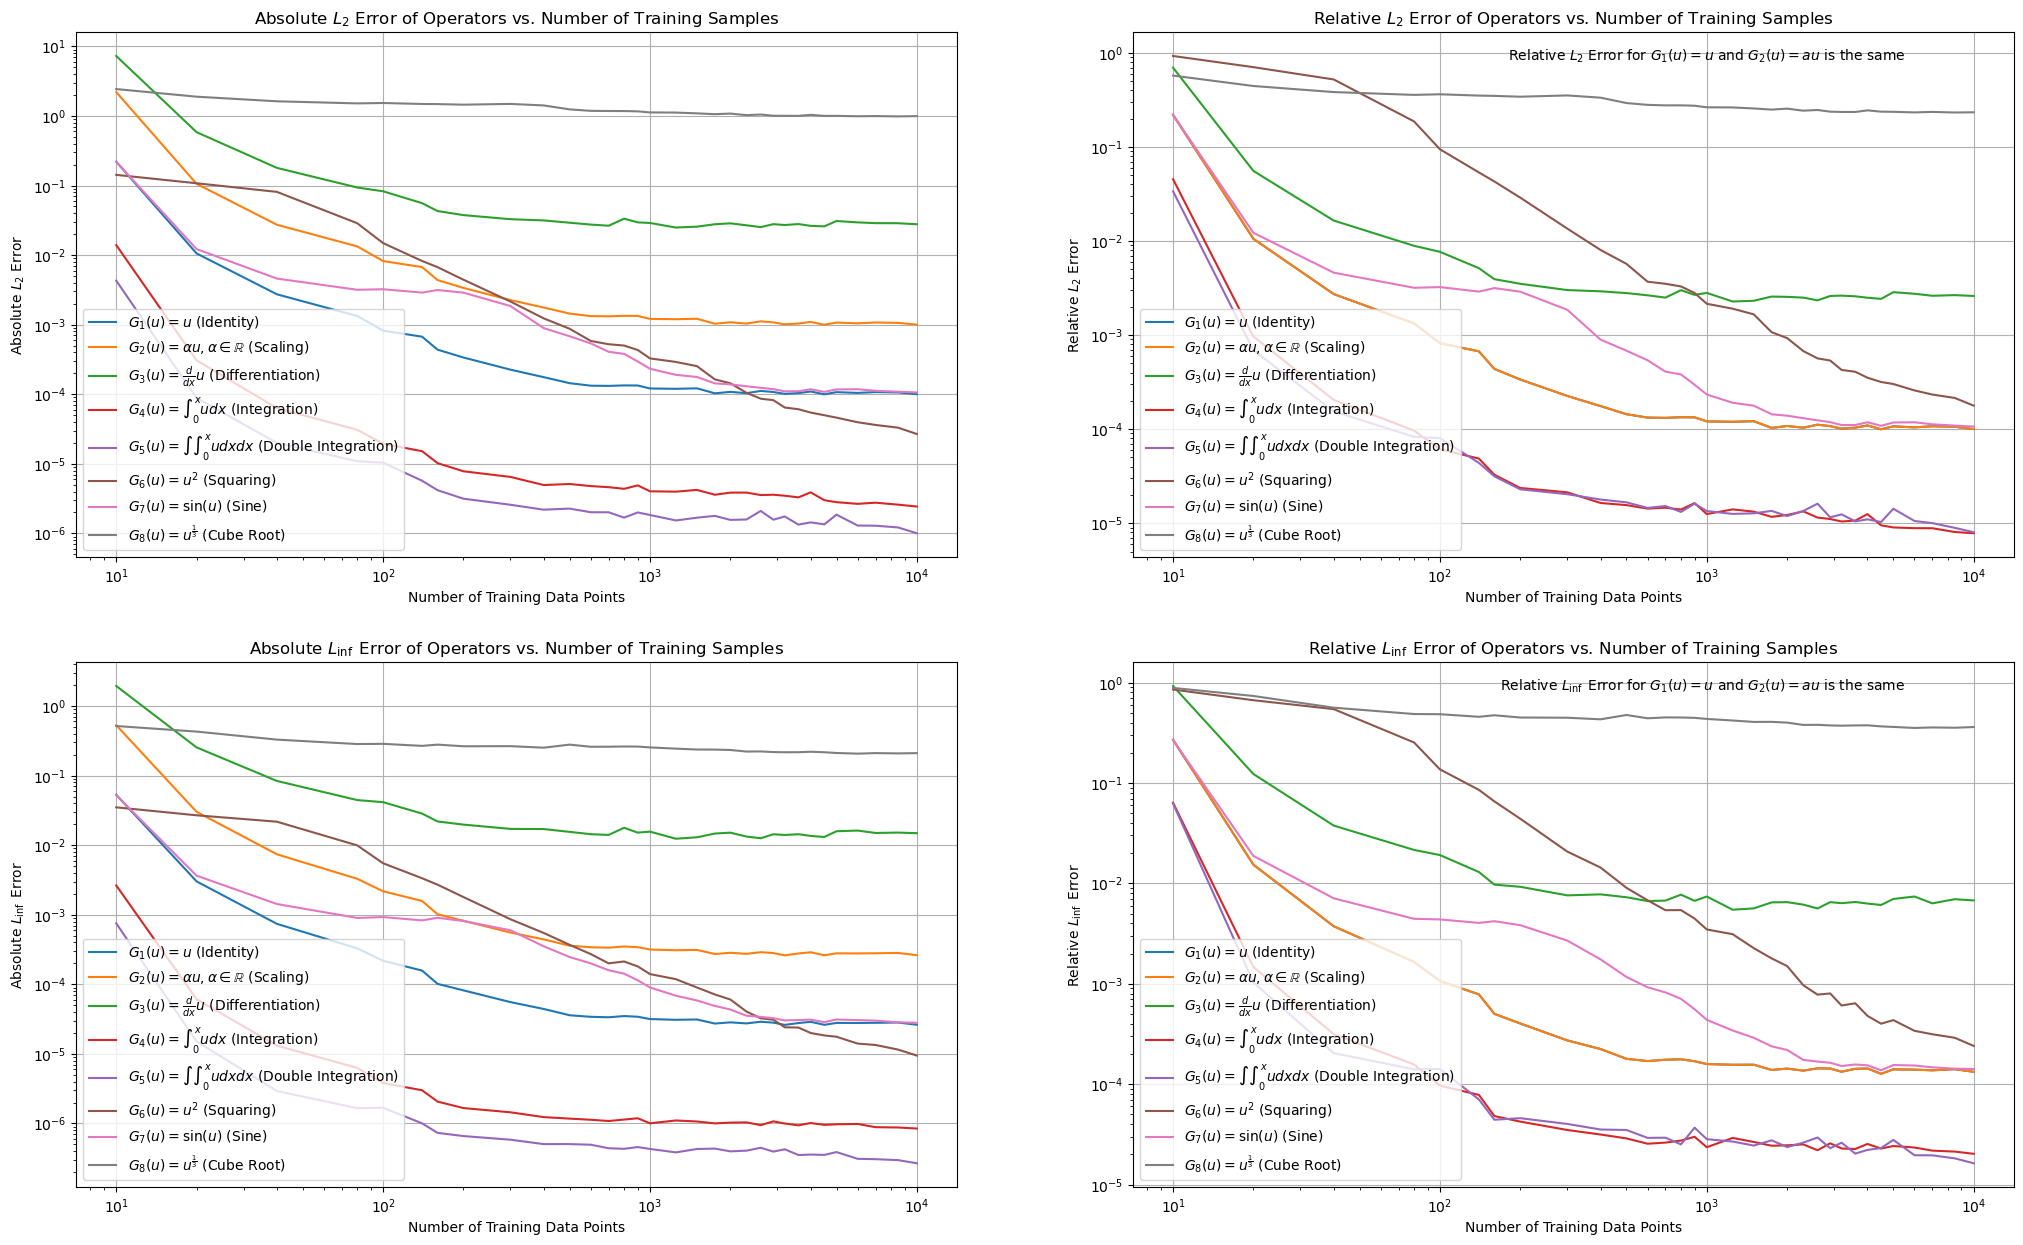

In [11]:
# Error Plots
fig, ax = plt.subplots(2,2)
fig.set_size_inches(25,15)

#ax[0,0].loglog(np.outer(np.ones((5,)),N).T,L1_Errs.T)
#ax[0,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_1$ Error', title = "Absolute $L_1$ Error of Operators vs. Number of Training Samples")
#ax[0,0].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
#ax[0,0].grid()

#ax[0,1].loglog(np.outer(np.ones((5,)),N).T,L1_Errs_Rel.T)
#ax[0,1].set( xlabel ='Number of Training Data Points', ylabel='Relative $L_1$ Error', title = "Relative $L_1$ Error of Operators vs. Number of Training Samples")
#ax[0,1].legend(['$G(u) = u$ (Identity)', r'$G(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G(u) = u^2$ (Squaring)', '$G(u) = \sin(u)$ (Sine)', '$G(u) = \int_0^x u dx$ (Integration)'])
#ax[0,1].grid()

ax[0,0].loglog(np.outer(np.ones((Num_ops,)),N).T,L2_Errs.T)
ax[0,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_2$ Error', title = "Absolute $L_2$ Error of Operators vs. Number of Training Samples")
ax[0,0].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax[0,0].grid()

ax[0,1].loglog(np.outer(np.ones((Num_ops,)),N).T,L2_Errs_Rel.T)
ax[0,1].set( xlabel ='Number of Training Data Points', ylabel='Relative $L_2$ Error', title = "Relative $L_2$ Error of Operators vs. Number of Training Samples")
ax[0,1].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax[0,1].grid()
ax[0,1].annotate('Relative $L_2$ Error for $G_1(u) = u$ and $G_2(u) = au$ is the same', xy=(0.9, 0.9), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')

ax[1,0].loglog(np.outer(np.ones((Num_ops,)),N).T,Linf_Errs.T)
ax[1,0].set( xlabel ='Number of Training Data Points', ylabel='Absolute $L_\inf$ Error', title = "Absolute $L_\inf$ Error of Operators vs. Number of Training Samples")
ax[1,0].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax[1,0].grid()

ax[1,1].loglog(np.outer(np.ones((Num_ops,)),N).T,Linf_Errs_Rel.T)
ax[1,1].set( xlabel ='Number of Training Data Points', ylabel='Relative $L_\inf$ Error', title = "Relative $L_\inf$ Error of Operators vs. Number of Training Samples")
ax[1,1].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax[1,1].grid()
ax[1,1].annotate('Relative $L_\inf$ Error for $G_1(u) = u$ and $G_2(u) = au$ is the same', xy=(0.9, 0.9), xycoords='axes fraction', xytext=(-20, 20), textcoords='offset pixels', horizontalalignment='right', verticalalignment='bottom')


fig.savefig('Error_Plots_F1.png', dpi=300, bbox_inches='tight')

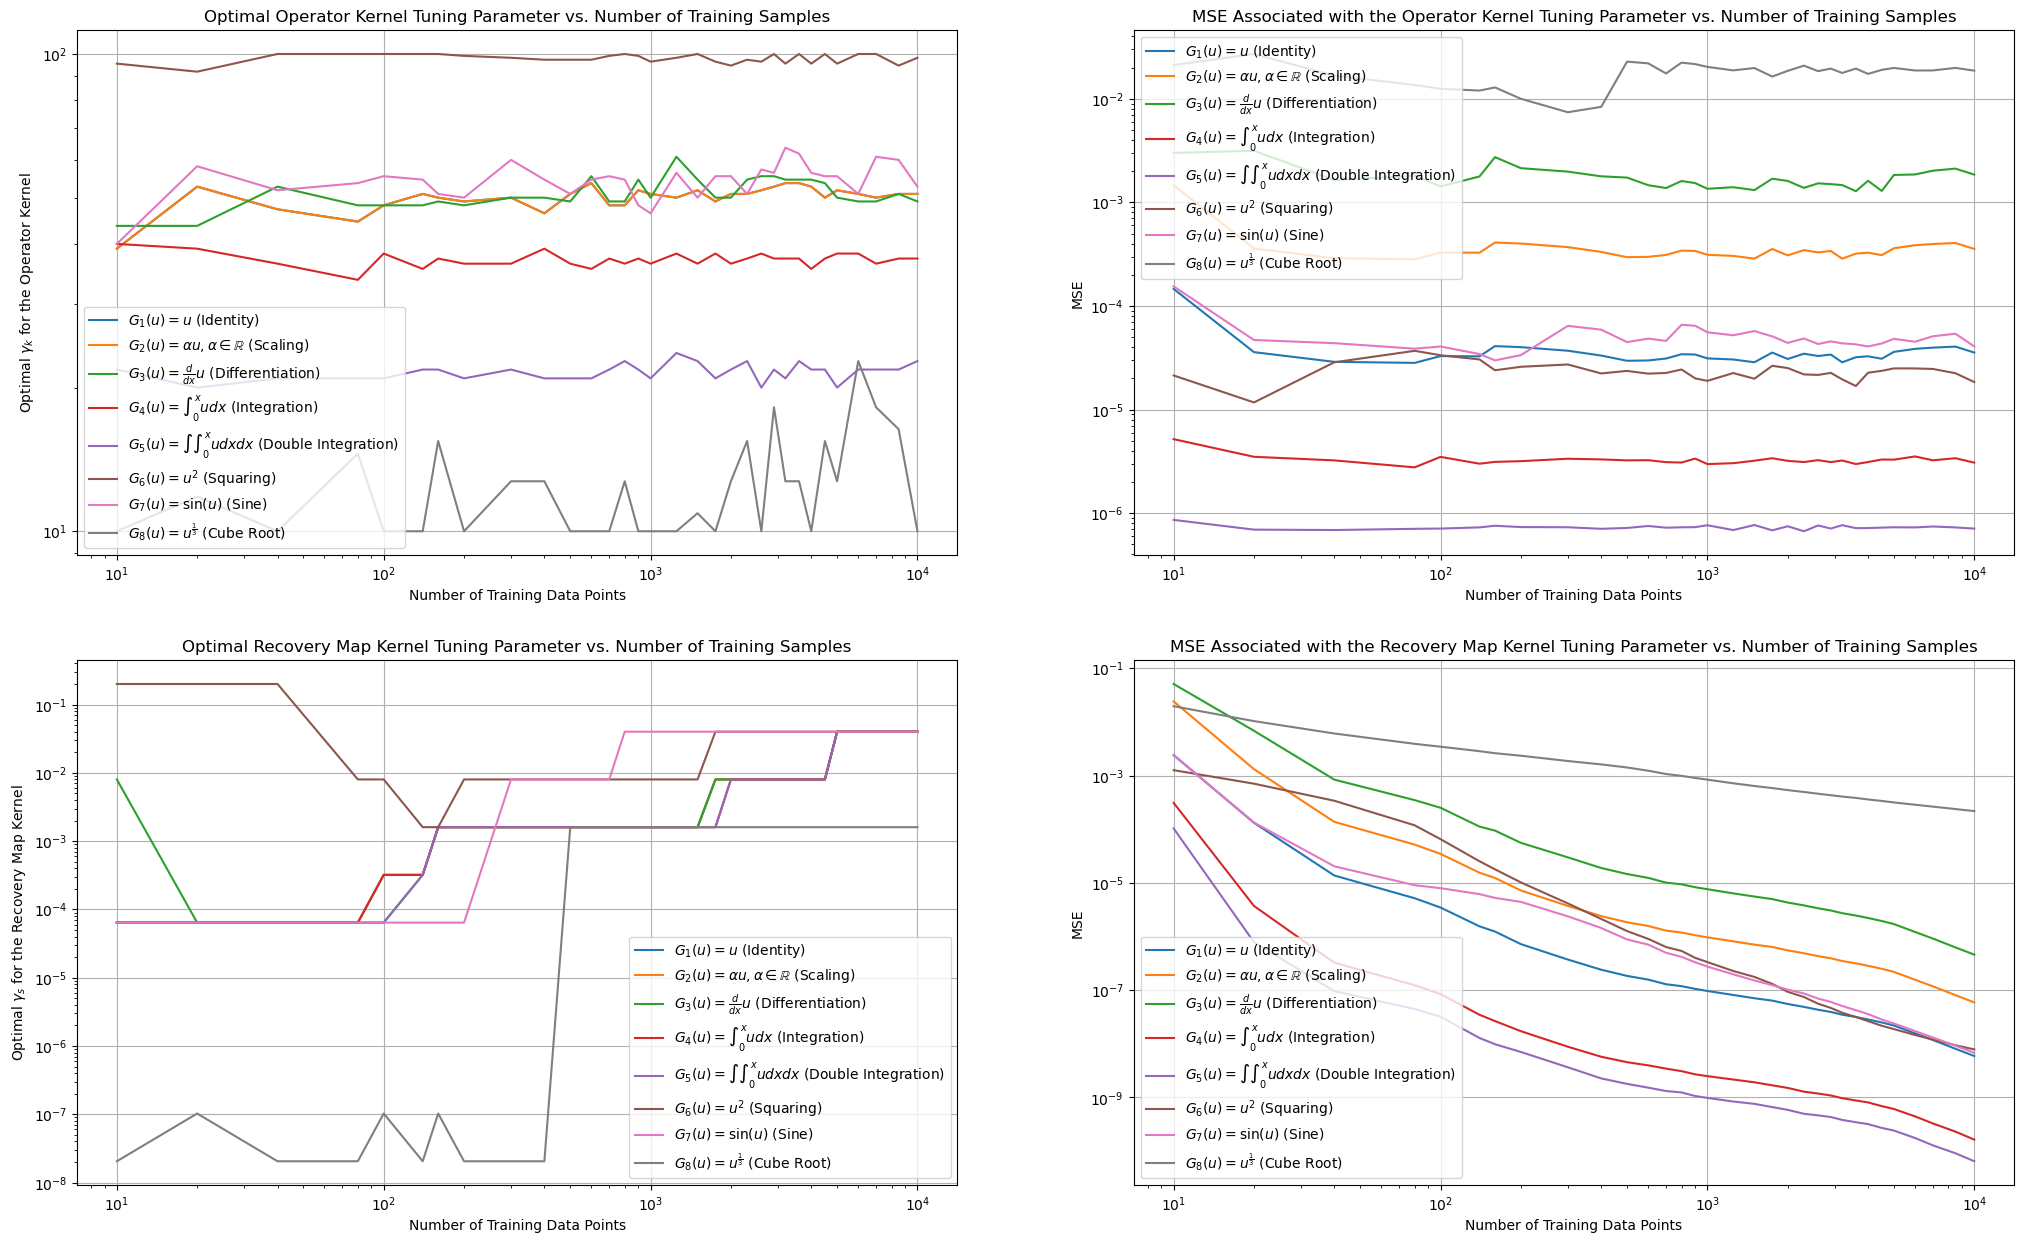

In [12]:
fig1, ax1 = plt.subplots(2,2)
fig1.set_size_inches(25,15)

ax1[0,0].loglog(np.outer(np.ones((Num_ops,)),N).T,Opt_Gamma_k.T)
ax1[0,0].set( xlabel ='Number of Training Data Points', ylabel='Optimal $\gamma_k$ for the Operator Kernel', title = "Optimal Operator Kernel Tuning Parameter vs. Number of Training Samples")
ax1[0,0].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax1[0,0].grid()

ax1[0,1].loglog(np.outer(np.ones((Num_ops,)),N).T,Opt_MSE_k.T)
ax1[0,1].set( xlabel ='Number of Training Data Points', ylabel='MSE', title = "MSE Associated with the Operator Kernel Tuning Parameter vs. Number of Training Samples")
ax1[0,1].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax1[0,1].grid()

ax1[1,0].loglog(np.outer(np.ones((Num_ops,)),N).T,Opt_Gamma_s.T)
ax1[1,0].set( xlabel ='Number of Training Data Points', ylabel='Optimal $\gamma_s$ for the Recovery Map Kernel', title = "Optimal Recovery Map Kernel Tuning Parameter vs. Number of Training Samples")
ax1[1,0].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax1[1,0].grid()

ax1[1,1].loglog(np.outer(np.ones((Num_ops,)),N).T,Opt_MSE_s.T)
ax1[1,1].set( xlabel ='Number of Training Data Points', ylabel='MSE', title = "MSE Associated with the Recovery Map Kernel Tuning Parameter vs. Number of Training Samples")
ax1[1,1].legend(['$G_1(u) = u$ (Identity)', r'$G_2(u) = \alpha u, \alpha \in \mathbb{R}$ (Scaling)', '$G_3(u) = \\frac{d}{dx} u$ (Differentiation)', '$G_4(u) = \int_0^x u dx$ (Integration)', '$G_5(u) = \int \int_0^x u dx dx$ (Double Integration)','$G_6(u) = u^2$ (Squaring)', '$G_7(u) = \sin(u)$ (Sine)','$G_8(u) = u^{\\frac{1}{3}}$ (Cube Root)'])
ax1[1,1].grid()

fig1.savefig('Opt_Gamma_MSE_F.png', dpi=300, bbox_inches='tight')

In [17]:
print(Opt_MSE_s[:,15])

[9.68061670e-08 9.68061668e-07 7.63854624e-06 2.49991079e-09
 9.82187338e-10 3.34723546e-07 2.76112244e-07 8.43277505e-04]
